# Topic Modeling and Gibbs Sampling

Задача: описать текст через распределение весов по некоторому фиксированному набору топиков (тегов). Например, для набора тегов Политика, Военные сражения, Спорт, Интернет, Драма представить роман "Война и мир" как вектор (0.3, 0.2, 0, 0, 0.5), а статью в газете про допинг в велоспорте как вектор (0.1, 0, 0.7, 0, 0.2).

Для чего, например, это нужно: имея векторное представление для текстов, тексты можно сравнивать, рекомендовать похожие.

Условие: даны только набор текстов и количество тем.

## Немного теории

Предположим, что всего имеется $K$ тегов и для каждого тега $k$ выбрано распределение $\phi_k$ над списком всевозможных слов (словарем из $N$ слов). По сути, каждое $\phi_k$ - это вектор длины $N$ из неотрицательных величин, в сумме дающих 1. Будем полагать, что $\phi_k$ моделируется [распределением Дирихле](https://en.wikipedia.org/wiki/Dirichlet_distribution) $Dir(\phi | \beta)$ независимо для каждого $k$.

Кроме того, каждый документ $d$ характеризуется своим собственным распределением над тегами, обозначим его $\theta_d$, где $\theta_d$ - вектор длины K из неотрицательных величин, суммирующихся к 1.

Будем представлять текст (документ) как неупорядоченный набор слов (Bag-of-words model). Опишем, как устроена вероятностная модель, моделирующая один документ из n слов:

* сначала нужно получить вектор $\theta_d$, задающий смесь тегов в документе. Предположим, что $\theta_d$ моделируется распределением Дирихле $Dir(\theta | \alpha)$.
* далее, для каждого слова i от 1 до n:
  * выберем тег $z_i$ согласно распределению $\theta_d$
  * выберем слово $w_i$ из распределения для данного тега, т.е. $w_i \sim \phi_{z_i}$
  * добавляем слово $w_i$ в документ.

Для моделирования набора из $M$ документов, повторяем процедуру генерации одного документа $M$ раз.

Полученная модель для набора документов называется моделью LDA (Latent Dirichlet Allocation). Описанная  схема задает совместное распределение скрытых и наблюдаемых параметров по всем текстам корпуса размера $M$ в виде:


$p(\textbf{w}, \textbf{z}, \theta, \phi | \alpha, \beta) = Dir(\theta | \alpha) Dir(\phi|\beta)Cat(\textbf{z}|\theta)Cat(\textbf{w}|\phi_z)$.

Здесь $\textbf{w}=(w^1_1, ..., w^1_{n_1}, w^2_1, ..., w^2_{n_2}, ..., w^M_1, ..., w^M_{n_M})$ и $\textbf{z}=(z^1_1, ..., z^1_{n_1}, z^2_1, ..., z^2_{n_2}, ..., z^M_1, ..., z^M_{n_M})$ обозначают вектора слов и тегов по всем текстам, $\theta$ - набор из распределений $\theta_d$ для каждого документа ($\theta$ можно представлять матрицей $M\times K$), $\phi$ - набор из распределений $\phi_k$ для каждого тега ($\phi$ можно представлять матрицей $K\times N$).


![img](https://www.researchgate.net/publication/336065245/figure/fig1/AS:807371718815752@1569503826964/Latent-Dirichlet-allocation-LDA-process-and-its-two-outputs-a-LDA-document.ppm)

**Наша задача - восстановить распределение $p(\textbf{z}, \theta, \phi | \textbf{w}, \alpha, \beta)$**, т.е. одновременно оценить распределение по темам для каждого слова из документа, для каждого документа и распределение над словарем для каждой темы.


Немного упростим жизнь, и поставим себе задачей восстановить распределение $p(\textbf{z} | \textbf{w}, \alpha, \beta) = \int\int p(\textbf{z}, \theta, \phi | \textbf{w}, \alpha, \beta)\textrm{d}\theta\textrm{d}\phi$. Затем, зная распределение для каждого слова из документа по темам, будем оценивать распределение по темам для документа в целом и распределения $\phi_k$.

Для оценки $p(\textbf{z} | \textbf{w}, \alpha, \beta)$ на помощь приходить алгоритм Gibbs Sampling, в котором для оценки распределения вектора $\textbf{z} = (z_1, z_2, ..., z_m)$ используется итерационная схема:

* начинаем с некоторого $\textbf{z}^0=(z_1^0,z_2^0,...,z_m^0)$
* для всех $t=1, 2, ...:$
  * для всех $i=1, 2, ...m:$

    $z_i^{(t)} \sim p(z_i^{(t)}\ | \ z_1=z_1^{t}, ..., z_{i-1}=z_{i-1}^{t},
    z_{i+1}=z_{i+1}^{t-1}, z_{m}=z_{m}^{t-1})$.

Условные распределения выводятся так. Сначала замечаем, что

$$p(z_i|\textbf{z}_{\hat{i}}, \textbf{w}, \alpha, \beta) = \frac{p(z_i,\textbf{z}_{\hat{i}}, \textbf{w}| \alpha, \beta)}{p(\textbf{z}_{\hat{i}}, \textbf{w}| \alpha, \beta)}  = \frac{p(\textbf{z}, \textbf{w}| \alpha, \beta)}{p(\textbf{z}_{\hat{i}}, \textbf{w}_{\hat{i}}| \alpha, \beta)  p(w_i|\alpha, \beta)}\,.$$

Здесь $\textbf{z}_{\hat{i}}$, $\textbf{w}_{\hat{i}}$ - вектора без $i$-oй компоненты.

Далее расписываем ($Cat(x|p)$ обозначает дискреное распределение для величины $x$ с набором вероятностей $p$):

$$p(\textbf{z}, \textbf{w}| \alpha, \beta) = \int\int p(\textbf{z}, \textbf{w}, \theta, \phi| \alpha, \beta)\textrm{d}\theta\textrm{d}\phi = \\ =\int\int Dir(\theta | \alpha) Dir(\phi|\beta)Cat(\textbf{z}|\theta)Cat(\textbf{w}|\phi_z)\textrm{d}\theta\textrm{d}\phi = \\
=\int Dir(\theta | \alpha) Cat(\textbf{z}|\theta)\textrm{d}\theta\int Dir(\phi|\beta)Cat(\textbf{w}|\phi_z)\textrm{d}\phi$$

и обнаруживаем, что оба интеграла в последнем выражении вычисляются аналитически. Для примера первый:

$$\int Dir(\theta | \alpha) Cat(\textbf{z}|\theta)\textrm{d}\theta = \prod\limits_d \int Dir(\theta_d | \alpha) Cat(\textbf{z}_d|\theta_d)\textrm{d}\theta_d = \\
=\prod\limits_d \int \frac{1}{B(\alpha)}\prod\limits_k \theta_{d, k}^{\alpha-1}\prod\limits_i \theta_{d, z_i}\textrm{d}\theta_d = \\
=\prod\limits_d\frac{1}{B(\alpha)}\int\prod\limits_k \theta_{d, k}^{n_{d, k} + \alpha - 1}\textrm{d}\theta_d = \prod\limits_d \frac{B(n_{d} + \alpha)}{B(\alpha)}\,.$$

Здесь
* $\alpha = (\alpha_1, ..., \alpha_K)$
* $n_{d,k}$ - количество тэгов $k$ в тексте $d$
* $n_{d} = (n_{d,1}, ..., n_{d,K})$
* $\theta_{d,k}$ - элемент из строки $d$ и столбца $k$ матрицы $\theta$ (вспомним, что $\theta$ договорились представлять матрицей $M\times K$
* $\theta_{d,z_i}$ - элемент из строки $d$ и столбца $z_i$ матрицы $\theta$
* $\textrm{d}\theta_d=\textrm{d}\theta_{d, 1}...\theta_{d, K}$
* $n_{d} + \alpha = (n_{d,1} + \theta_{d, 1}, ..., n_{d,K} + \theta_{d, K})$

Аналогично, второй интеграл
$$\int Dir(\phi|\beta)Cat(\textbf{w}|\phi_z)\textrm{d}\phi = \prod\limits_k \frac{B(n_{k} + \beta)}{B(\beta)}\,$$

где
* $n_{k}=(n_{k,1}, ..., n_{k, N})$ - вектор длины $N$ встречаемости слов внутри тэга $k$
* $\beta=(\beta_1, ..., \beta_N)$

Получаем:

$$p(\textbf{z}, \textbf{w}| \alpha, \beta) = \prod\limits_d \frac{B(n_{d} + \alpha)}{B(\alpha)} \prod\limits_k \frac{B(n_{k} + \beta)}{B(\beta)}\, .$$

Теперь
$$p(z_i|\textbf{z}_{\hat{i}}, \textbf{w}, \alpha, \beta) \propto \prod\limits_d \frac{B(n_{d} + \alpha)}{B(n_{d}^{\hat{i}} + \alpha)} \prod\limits_k \frac{B(n_{k} + \beta)}{B(n_{k}^{\hat{i}} + \beta)}\,.$$

Знак $\propto$ означает пропорциональность с точностью до общего множителя $p(w_i|\alpha, \beta)$. Векторы $n_{d}^{\hat{i}}$ и $n_{k}^{\hat{i}}$ получены из векторов $n_{d}$ и $n_{k}$ после выбрасывания $z_i$.

Выражение упрощается дальше, расписывая бета-функцию через гамма-функции. Напомним,
$B(x_1, ..., x_m) = \frac{\Gamma(x_1)\cdot...\cdot\Gamma(x_m)}{\Gamma(x_1 + ... + x_m)}$, а также $\Gamma(n) = (n-1)\Gamma(n-1)$. Получим:

$$p(z_i=k |\textbf{z}_{\hat{i}}, \textbf{w}, \alpha, \beta) \propto (n_{d_i, k}^{\hat{i}} + \alpha_k) \frac{n_{k, w_i}^{\hat{i}} + \beta_{w_i}}{\sum\limits_{w}(n_{k, w}^{\hat{i}} + \beta_{w})}\,. $$


С этого места можно полностью собрать алгоритм моделирования плотности $p(\textbf{z}| \textbf{w}, \alpha, \beta)$. Введем  обозначения
* $n_k$ - количество слов, отнесенных к тегу $k$, по всем документам
* $n_{k, w}$ - количество раз, когда слово $w$ вошло в тег $k$
* $n_{d, k}$ - количество вхождений тега $k$ в документ $d$
* $W$ - общее количество слов в корпусе документов
* $\beta_{sum} = \sum\limits_{w=1}^{N}\beta_w$

Алгоритм:

* заведем счетчики $n_{k, w}$, $n_{d, k}$, $n_k$
* зададим априорные $\beta$, $\alpha$
* случайным образом расставим теги словам, обновим счетчики $n_{k, w}$, $n_{d, k}$, $n_k$
* пока не сойдемся к стационарному режиму:
  * для каждого $i$ от 1 до $W$:
      * для каждого $k$ от 1 до $K$:
        * $I := I(z_i = k)$ (индикатор)
        * вычисляем $p_k = (n_{d_i, k} + \alpha_k - I) \frac{n_{k, w_i} + \beta_{w_i} - I}{n_k + \beta_{sum} - I}$
      * сэмплим новый $z_i$ из полученного распределения $(p_1, ..., p_K)$
      * обновляем счетчики для учета обновленого значения $z_i$

На практике удобно реализовавать так:

* заведем счетчики $n_{k, w}$, $n_{d, k}$, $n_k$, заполненные нулями
* случайным образом расставим теги словам, обновим счетчики $n_{k, w}$, $n_{d, k}$, $n_k$
* пока не сойдемся к стационарному режиму:
  * для каждого $i$ от 1 до $W$:
      * $n_{d_i, z_i} \mathrel{-}= 1$, $n_{z_i, w_i} \mathrel{-}= 1$, $n_{z_i} \mathrel{-}= 1$
      * для каждого $k$ от 1 до $K$:
        * вычисляем $p_k = (n_{d, k} + \alpha_k) \frac{n_{k, w_i} + \beta_{w_i}}{n_k + \beta_{sum}}$
      * сэмплим новый $z_i$ из полученного распределения $(p_1, ..., p_K)$
      * $n_{d_i, z_i} \mathrel{+}= 1$, $n_{z_i, w_i} \mathrel{+}= 1$, $n_{z_i} \mathrel{+}= 1$





Восстановив распредление для $\textbf{z}$, можем оценить $\theta$ и $\phi$. Апостериорные распределения имеют вид:

$\theta_d\sim Dir(\alpha + n_d)$

$\phi_k\sim Dir(\beta + n_k)$

где $n_d$, $n_k$ берутся после завершения работы алгоритма LDA.

Литература:

http://www2.stat.duke.edu/~rcs46/modern_bayes17/lecturesModernBayes17/lecture-7/07-gibbs.pdf

https://www.cs.cmu.edu/~mgormley/courses/10701-f16/slides/lecture20-topic-models.pdf

Перейдем к практике.

## Датасет

Возьмем популярный датасет [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/), встроенный в пакет ```sklearn```. Датасет состоит из ~20К текстов, классифицированных на 20 категорий. Датасет разбит на ```train``` и ```test```. Для загрузки используем  модуль ```fetch_20newsgroups```, в параметрах указать, что мета информацию о тексте загружать не нужно:

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

Выведем список категорий текстов:

In [2]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Атрибут ```traget``` хранит номера категорий для текстов из обучающей выборки:

In [3]:
newsgroups_train.target[:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

Доступ к самим текстам через атрибут ```data```. Выведем текст и категорию случайного примера из обучающего датасета:

In [4]:
n = 854
print('Topic = {0}\n'.format(newsgroups_train.target_names[newsgroups_train.target[n]]))
print(newsgroups_train.data[n])

Topic = rec.motorcycles

hey... I'm pretty new to the wonderful world of motorcycles... I just
bought
a used 81 Kaw KZ650 CSR from a friend.... I was just wondering what kind of

saddle bags I could get for it (since I know nothing about them)  are there
bags for the gas tank?  how much would some cost, and how much do they
hold?
thanks for your advice!!!  I may be new to riding, but I love it
already!!!!
:)




## Векторное представление текста

Представим текст как вектор индикаторов вхождений слов из некоторого словаря в текст. Это простейшая модель BOF.

Сформируем словарь на основе нашего набора текстов. Для этого используем модуль ```CountVectorizer```:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=True, stop_words="english",
                             analyzer='word', binary=True)
vectorizer.fit(newsgroups_train.data)

CountVectorizer(binary=True, stop_words='english')

Количество проиндексированных слов:

In [6]:
len(vectorizer.vocabulary_)

101322

Проиндексированные слова и их индексы:

In [7]:
vectorizer.vocabulary_

{'wondering': 96879,
 'enlighten': 37256,
 'car': 25717,
 'saw': 80420,
 'day': 31927,
 'door': 34741,
 'sports': 84312,
 'looked': 57247,
 'late': 55606,
 '60s': 9843,
 'early': 35902,
 '70s': 11174,
 'called': 25437,
 'bricklin': 24108,
 'doors': 34742,
 'really': 76269,
 'small': 83208,
 'addition': 16806,
 'bumper': 24583,
 'separate': 81450,
 'rest': 77676,
 'body': 23430,
 'know': 54493,
 'tellme': 87913,
 'model': 62594,
 'engine': 37208,
 'specs': 84050,
 'years': 99608,
 'production': 73174,
 'history': 46690,
 'info': 49800,
 'funky': 41874,
 'looking': 57250,
 'mail': 59071,
 'fair': 39296,
 'number': 66680,
 'brave': 23973,
 'souls': 83779,
 'upgraded': 92389,
 'si': 82337,
 'clock': 27889,
 'oscillator': 68519,
 'shared': 81848,
 'experiences': 38637,
 'poll': 72039,
 'send': 81378,
 'brief': 24125,
 'message': 60923,
 'detailing': 33127,
 'procedure': 73122,
 'speed': 84088,
 'attained': 20236,
 'cpu': 30233,
 'rated': 75904,
 'add': 16791,
 'cards': 25769,
 'adapters': 1

Индекс, например, для слова car:

In [8]:
vectorizer.vocabulary_.get('car')

25717

А теперь преобразуем строку в вектор:

In [9]:
text = 'I was wondering if anyone out there could enlighten me on this car I saw'
x = vectorizer.transform([text])

In [10]:
x.shape

(1, 101322)

Какой тип имеет объект, на который указывает ```x```?

In [11]:
type(x)

scipy.sparse._csr.csr_matrix

Разреженная матрица!

### Отступление про разреженные матрицы

Список ненулевых элементов матрицы:

In [12]:
x.data

array([1, 1, 1, 1], dtype=int64)

Индексы строк и столбцов для ненулевых элементов:

In [13]:
x.nonzero()

(array([0, 0, 0, 0]), array([25717, 37256, 80420, 96879]))

Преобразование к объекту ndarray (именно после приведения к такому виду разреженные матрицы можно подставлять в функции, например, библиотеки Numpy):

In [14]:
x.toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Вернемся к словарю. Раскодируем вектор ```x``` в список слов:

In [15]:
vectorizer.inverse_transform(x)

[array(['car', 'enlighten', 'saw', 'wondering'], dtype='<U81')]

Пропало слово ```I```. Но дело в том, что по умолчанию ```CountVectorizer``` отбрасывает последовательности, короче 2 символов. На это указывает параметр ```token_pattern='(?u)\\b\\w\\w+\\b'```.

Переведем весь набор текстов обучающего датасета в набор векторов, получим матрицу ```X_train```:

In [16]:
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_train.shape

(11314, 101322)

О пользе разреженных матриц. Отношение числа ненулевых элементов ко всем элементам матрицы ```X_train```:

In [17]:
X_train.nnz / np.prod(X_train.shape)

0.0006593137467596179


Задача: запустить модель LDA и Gibbs Sampling с числов тегов 20. Вывести топ-10 слов по каждому тегу. Соотнести полученные теги с тегами из датасета. Добейтесь того, чтобы хотя бы несколько тем были явно интерпретируемы, например, как в примерах ниже.

Примеры топ-10 слов из некотрых тегов, которые получаются после применения LDA:
* ['god', 'jesus', 'believe', 'life', 'bible', 'christian', 'world', 'church', 'word', 'people'] - эта группа явно соотносится с soc.religion.christian
* ['drive', 'card', 'hard', 'bit', 'disk', 'scsi', 'memory', 'speed', 'mac', 'video'] - эту группу можно соотнести с темами 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware'
* ['game',	'games',	'hockey',	'league',	'play',	'players',	'season',	'team',	'teams',	'win'] - тема rec.sport.hockey

Советы:
* модель будет сходится лучше и быстрее, если уменьшить размер словаря за счет отсеивания общеупотребительных слов и редких слов. Управлять размером словаря можно с помощью параметров min_df (отсеивает слова по минимальной частоте встречаемости) и max_df (отсеивает слова по максимальной частоте встречаемости) в CountVectorizer.
* параметры $\alpha$, $\beta$ можно, для начала, положить единицами
* после 100 итераций можно ожидать хорошего распределения по темам. Если этого не происходит и в темах мешинина - проверяйте код и оптимизируйте словарь
* на примере третьей темы видно, что у нас встречаются разные формы одного и того же слова. С помощью процедур stemming и lemmatization можно привести слова к общей форме и объединить близкие по значению

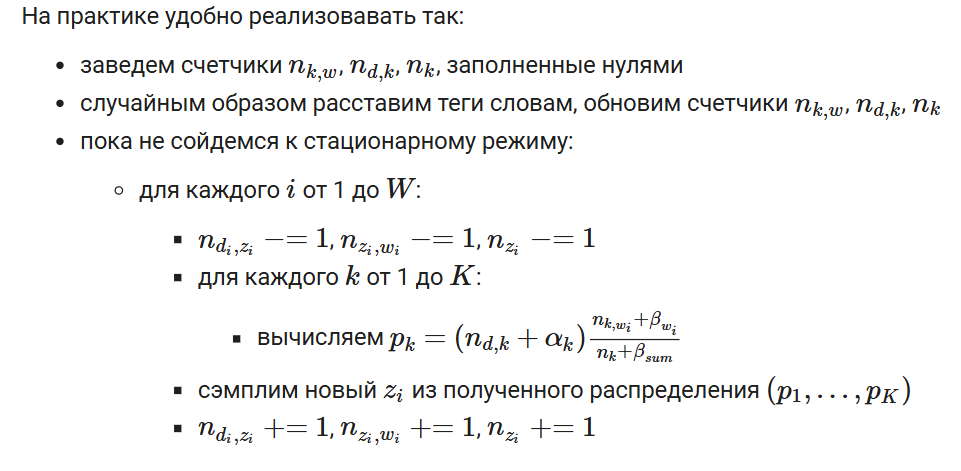

In [27]:
import numpy as np
from collections import Counter
from scipy.sparse import csr_matrix
from tqdm import tqdm

class LDA:
    def __init__(self, n_topics=20, alpha=1, beta=1, n_iter=1000):
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta
        self.n_iter = n_iter

    def fit(self, raw_documents):
        vectorizer = CountVectorizer(lowercase=True, stop_words="english", analyzer="word", binary=True, max_features=5000)
        X = vectorizer.fit_transform(raw_documents)
        feature_names = vectorizer.get_feature_names_out()
        self.n_docs, self.vocab_size = X.shape
        self.vocab = feature_names
        self.word2id = {word: i for i, word in enumerate(self.vocab)}
        self.id2word = {i: word for word, i in self.word2id.items()}
        self.word_topic_count = np.zeros((self.vocab_size, self.n_topics), dtype=np.int32)
        self.doc_topic_count = np.zeros((self.n_docs, self.n_topics), dtype=np.int32)
        self.topic_count = np.zeros(self.n_topics, dtype=np.int32)
        self.topic_assignments = []
        documents = [list(X[doc_idx].indices) for doc_idx in range(self.n_docs)]
        
        for d_idx, doc in enumerate(documents):
            current_doc_topics = []
            for word_id in doc:
                topic = np.random.choice(self.n_topics)
                current_doc_topics.append(topic)

                self.word_topic_count[word_id, topic] += 1
                self.doc_topic_count[d_idx, topic] += 1
                self.topic_count[topic] += 1

            self.topic_assignments.append(current_doc_topics)
            
        for iteration in tqdm(range(self.n_iter)):
            for d_idx, doc in enumerate(documents):
                for w_idx, word_id in enumerate(doc):
                    current_topic = self.topic_assignments[d_idx][w_idx]
                    self.word_topic_count[word_id, current_topic] -= 1
                    self.doc_topic_count[d_idx, current_topic] -= 1
                    self.topic_count[current_topic] -= 1
                    topic_probs = (self.word_topic_count[word_id] + self.beta) * (self.doc_topic_count[d_idx] + self.alpha) / (self.topic_count + self.beta * self.vocab_size)
                    new_topic = np.random.choice(self.n_topics, p=topic_probs / topic_probs.sum())
                    self.word_topic_count[word_id, new_topic] += 1
                    self.doc_topic_count[d_idx, new_topic] += 1
                    self.topic_count[new_topic] += 1
                    self.topic_assignments[d_idx][w_idx] = new_topic

    def get_topics(self, n_words=10):
        topics = []
        for topic_idx in range(self.n_topics):
            top_words = np.argsort(self.word_topic_count[:, topic_idx])[::-1][:n_words]
            topics.append([self.id2word[i] for i in top_words])
        return topics

In [29]:
lda = LDA(n_iter=100)
lda.fit(newsgroups_train.data)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:39:54<00:00, 59.95s/it]


In [30]:
topics = lda.get_topics()
for i, topic in enumerate(topics):
    print(f"Topic {i}: {', '.join(topic)}")

Topic 0: people, law, gun, government, state, case, make, don, rights, control
Topic 1: car, good, bike, cars, right, time, work, just, like, engine
Topic 2: new, price, sale, interested, offer, used, sell, best, condition, shipping
Topic 3: game, year, team, games, play, win, season, players, league, better
Topic 4: key, chip, use, encryption, keys, clipper, government, public, using, phone
Topic 5: just, like, don, know, good, way, ve, think, sure, time
Topic 6: new, year, national, american, states, president, washington, public, support, april
Topic 7: 11, 15, 10, 12, 14, 20, 13, 16, 25, 18
Topic 8: did, went, day, old, told, got, came, didn, saw, took
Topic 9: edu, com, list, university, address, send, mail, internet, information, article
Topic 10: case, example, point, different, actually, number, given, similar, best, large
Topic 11: god, believe, people, say, jesus, does, bible, christian, point, christians
Topic 12: war, people, israel, jews, government, world, years, state, i